In [1]:
!pip install timm gputil

     |████████████████████████████████| 376 kB 592 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=a1fb74a529be6dd03a98b106ab96cf0fe6624b555bf3eb006648dec15778b4ed
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [2]:
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision.all import *
import timm
from timm import create_model
import torch
from numba import cuda
from GPUtil import showUtilization as gpu_usage

In [3]:
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swim-package/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


cp: cannot stat '../input/swim-package/swin_large_patch4_window7_224_22kto1k.pth': No such file or directory


In [4]:
train_im_dir = '../input/petfinder-pawpularity-score/train'
train_df = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv') 
train_df['Id'] = train_df['Id'].apply(lambda x: f"../input/petfinder-pawpularity-score/train/{x}.jpg")
train_df['Pawpularity'] = train_df['Pawpularity']/100
train_df = train_df.rename(columns={'Id': 'Path Id'})
train_df.head()

,Path Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg,0,1,1,1,0,0,1,0,0,0,0,0,0.63
1,../input/petfinder-pawpularity-score/train/0009c66b9439883ba2750fb825e1d7db.jpg,0,1,1,0,0,0,0,0,0,0,0,0,0.42
2,../input/petfinder-pawpularity-score/train/0013fd999caf9a3efe1352ca1b0d937e.jpg,0,1,1,1,0,0,0,0,1,1,0,0,0.28
3,../input/petfinder-pawpularity-score/train/0018df346ac9c1d8413cfcc888ca8246.jpg,0,1,1,1,0,0,0,0,0,0,0,0,0.15
4,../input/petfinder-pawpularity-score/train/001dc955e10590d3ca4673f034feeef2.jpg,0,0,0,1,0,0,1,0,0,0,0,0,0.72


In [5]:
fastai_dl = ImageDataLoaders.from_df(df = train_df,
                                     seed = 1997,
                                     fn_col = 'Path Id',
                                     label_col = 'Pawpularity',
                                     y_block = RegressionBlock,
                                     item_tfms=Resize(384),
                                     bs = 8,
                                     batch_tfms = setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()]))

In [6]:
#  'swin_base_patch4_window7_224',
#  'swin_base_patch4_window7_224_in22k',
#  'swin_base_patch4_window12_384',
#  'swin_base_patch4_window12_384_in22k',
#  'swin_large_patch4_window7_224',
#  'swin_large_patch4_window7_224_in22k',
#  'swin_large_patch4_window12_384',
#  'swin_large_patch4_window12_384_in22k',
#  'swin_small_patch4_window7_224',
#  'swin_tiny_patch4_window7_224',
# bs = 8 for 384 models and 16 for 224 models
model = create_model('swin_large_patch4_window12_384_in22k', pretrained=True, num_classes=fastai_dl.c)

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window12_384_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window12_384_22k.pth


In [7]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [8]:
# cuda.select_device(0)
# cuda.close()
# cuda.select_device(0)

# print("GPU Usage after emptying the cache")
# gpu_usage()

In [9]:
learn = Learner(fastai_dl, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()

SuggestedLRs(valley=0.00021930268849246204)

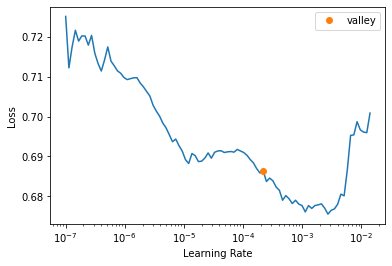

In [10]:
learn.lr_find(end_lr=3e-2)

In [11]:
learn.fit_one_cycle(10, 5.47e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=3)])

epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.643828,0.643913,17.716646,21:16
1,0.640176,0.641845,17.213938,21:16
2,0.645629,0.640397,17.218855,21:17
3,0.625960,0.649091,18.037704,21:17
4,0.613468,0.650085,18.019388,21:17


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6439129114151001.
Better model found at epoch 1 with valid_loss value: 0.6418448090553284.
Better model found at epoch 2 with valid_loss value: 0.6403973698616028.
No improvement since epoch 1: early stopping


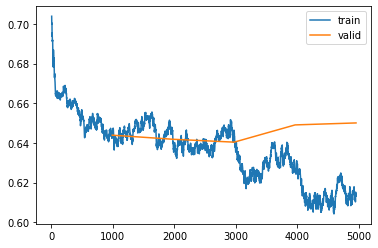

In [12]:
learn.recorder.plot_loss()

In [13]:
learn = learn.to_fp32()

In [14]:
learn.export()

In [15]:
test_df = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/test.csv') 
test_df['Id'] = test_df['Id'].apply(lambda x: f"../input/petfinder-pawpularity-score/test/{x}.jpg")
test_df = test_df.rename(columns={'Id': 'Path Id'})
test_df.head()

,Path Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,../input/petfinder-pawpularity-score/test/4128bae22183829d2b5fea10effdb0c3.jpg,1,0,1,0,0,1,1,0,0,1,0,1
1,../input/petfinder-pawpularity-score/test/43a2262d7738e3d420d453815151079e.jpg,0,1,0,0,0,0,1,1,0,0,0,0
2,../input/petfinder-pawpularity-score/test/4e429cead1848a298432a0acad014c9d.jpg,0,0,0,1,0,1,1,1,0,1,1,1
3,../input/petfinder-pawpularity-score/test/80bc3ccafcc51b66303c2c263aa38486.jpg,1,0,1,0,0,0,0,0,0,0,1,0
4,../input/petfinder-pawpularity-score/test/8f49844c382931444e68dffbe20228f4.jpg,1,1,1,0,1,1,0,1,0,1,1,0


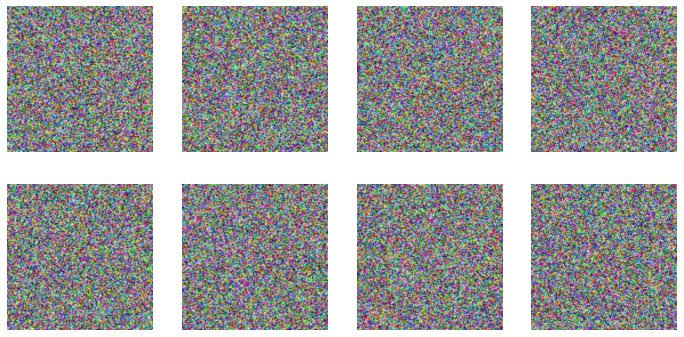

In [16]:
test_df['Pawpularity'] = [1]*len(test_df)
fastai_dl_test = fastai_dl.test_dl(test_df)
fastai_dl_test.show_batch()

In [17]:
preds, _ = learn.tta(dl=fastai_dl_test, n=5, beta=0)
sample_df = pd.read_csv('../input/petfinder-pawpularity-score/sample_submission.csv')
sample_df['Pawpularity'] = preds.float().numpy()*100
sample_df.to_csv('submission.csv',index=False)

In [18]:
sample_df

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,43.908588
1,43a2262d7738e3d420d453815151079e,45.112549
2,4e429cead1848a298432a0acad014c9d,44.767124
3,80bc3ccafcc51b66303c2c263aa38486,44.152134
4,8f49844c382931444e68dffbe20228f4,44.077969
5,b03f7041962238a7c9d6537e22f9b017,43.503128
6,c978013571258ed6d4637f6e8cc9d6a3,44.631329
7,e0de453c1bffc20c22b072b34b54e50f,44.397850
